We first import necessary packages.

In [120]:
!pip install gymnasium==0.29.0

In [121]:
import numpy as np
from numpy.testing import assert_almost_equal
from numpy.testing import assert_equal

import gymnasium as gym

import pprint
import matplotlib.pyplot as plt

# Frozen Lake MDP
Next, we instantiate the [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) environment from OpenAI Gymnasium and gain a quick understanding of its key variables and methods.

Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.

Follow the hyperlinks to learn more about the envionment [Frozen Lake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) and its [source code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/frozen_lake.py). Here is a version of the Frozen Lake environment where the frozen lake is a grid of size 4x4.

![FrozenLakeGif](https://www.gymlibrary.dev/_images/frozen_lake.gif)

In [122]:
env = gym.make("FrozenLake-v1", is_slippery=True)

In [123]:
print("Map:")
print(env.unwrapped.desc.astype('U'))

Map:
[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]


#### States

OpenAI Gymnasium environments do not explicitly provide state but instead provide observation. In the Frozen Lake environment, the state and observation are identical. The state denotes the position of the agent.

In [124]:
print(f"Number of states: {env.observation_space.n}")

Number of states: 16


#### Actions

In [125]:
print(f"Number of actions: {env.action_space.n}")

Number of actions: 4


#### Transition and Reward Function

The transition and rewards functions for Frozen Lake environment is represented in a different format than the one we have seen in the class. They are represented as a unified nested dictionary (P) of the format:

`{state: {action:
    list of (probability, next state, next reward, is terminal)}}.`

Let us first inspect this dictionary.

In [126]:
print(f"Transition and Reward functions for state=0 and action=0:")
pprint.pprint(env.unwrapped.P[0][0])

Transition and Reward functions for state=0 and action=0:
[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]


Now, we will convert it to the format seen in the class.

In [127]:
def get_mdp_parameters(env):
    """Helper method to retrieve MDP parameters.

    Args:
        env: Instance of the Frozen Lake MDP environment.

    Returns:
        num_states: Int, number of states.
        num_actions: Int, number of actions.
        transition_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the transition probabilities, T(s, a, s')
        reward_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the reward of R(s, a, s').
    """
    # Number of states and actions
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Helper variable: mapping from state to grid type
    flattened_map = env.unwrapped.desc.flatten()

    # Initialize Transition and Reward functions
    transition_fn = np.zeros(
        shape=(num_states, num_actions, num_states))
    reward_fn = np.zeros(
        shape=(num_states, num_actions, num_states))

    # Fill Transition and Reward functions
    for s in range(num_states):
        terminal = flattened_map[s] in [b"H", b"G"]
        for a in range(num_actions):
            if s is terminal:
                transition_fn[s, a, s] = 1.
                continue
            for prob_next_s, next_s, r, _ in env.unwrapped.P[s][a]:
                transition_fn[s, a, next_s] += prob_next_s
                reward_fn[s, a, next_s] = r


    # Ensure Transition function is indeed a probability distribution
    for s in range(num_states):
        for a in range(num_actions):
            assert_almost_equal(transition_fn[s,a].sum(), 1., decimal=7)

    # Return as a tuple
    return (num_states, num_actions, transition_fn, reward_fn)

In [128]:
num_states, num_actions, transition_fn, reward_fn = get_mdp_parameters(env)

# Problem 1.2

Next, we will write a program to compute the V-value of a given policy. See the starter code below and complete the missing parts. You can check your code using the tests below.

In [129]:
def policy_evaluation_v(policy, transition_fn, reward_fn, gamma=0.99, theta=1e-6):
    """Implements the policy evaluation algorithm to compute V values.

    Args:
        policy: A numpy ndarray of shape (num_states, num_actions) denoting
            the probability of selecting an action (a) in a given state (s).
        transition_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the transition probabilities, T(s, a, s')
        reward_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the reward of R(s, a, s').
        gamma: Discount factor.
        theta: Threshold for terminating policy evaluation.

    Returns:
        v_value: A numpy array of shape (num_states) denoting the value
            of state (s) for the given policy.
    """
    # Ensure input dimensions are consistent.
    num_states, num_actions, _ = transition_fn.shape
    assert_equal(num_states, transition_fn.shape[2])
    assert_equal(reward_fn.shape, transition_fn.shape)
    assert_equal(policy.shape, (num_states, num_actions))

    # Initialize value
    v_value = np.zeros(shape=(num_states, ))

    # Evaluate value
    while True:
        delta = 0
        ######## PUT YOUR CODE HERE ########

        # Loop through each state
        for s in range(num_states):

            # Save current value for state
            current_v = v_value[s]

            # Initialize outer sum
            sum1 = 0

            # Loop through actions
            for a in range(num_actions):

                # Initialize inner sum
                sum2 = 0

                # Loop through inner sum
                for s_prime, prob in enumerate(transition_fn[s, a, :]):

                    # Calculate inner sum
                    sum2 += prob * (reward_fn[s, a, s_prime] + gamma*v_value[s_prime])

                # Calculate outer sum
                sum1 += policy[s, a] * sum2

            # Set new value for state    
            v_value[s] = sum1

            # Calculate delta
            delta = max(delta, np.abs(current_v - v_value[s]))
            
        ######## PUT YOUR CODE HERE ########
        if delta < theta:
            break

    return v_value

In [130]:
transition_fn[0,0, :]

array([0.66666667, 0.        , 0.        , 0.        , 0.33333333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

#### Test Code
You can use the test code to check and develop your solution.

In [131]:
def test_policy_evaluation_v(test_policy, test_v_value, transition_fn, reward_fn, test_policy_name):
    """Test code for policy evaluation of V values."""
    v_value = policy_evaluation_v(test_policy, transition_fn, reward_fn)
    try:
        assert_almost_equal(v_value, test_v_value, decimal=2)
    except AssertionError:
        print("The V value of " + test_policy_name + " is incorrect.")
    else:
        print("The V value of " + test_policy_name + " is correct to at least 2 decimal values.")

In [132]:
policy_evaluation_v(a_test_policy, transition_fn, reward_fn)

NameError: name 'a_test_policy' is not defined

In [133]:
a_test_policy = np.full(fill_value=1. / num_actions, shape=(num_states, num_actions))
a_test_v_value = np.array(
        [0.01235356, 0.01042298, 0.01933735, 0.00947697,
         0.01478582, 0.        , 0.03889412, 0.        ,
         0.0326019 , 0.08433739, 0.13781067, 0.        ,
         0.        , 0.17034467, 0.43357932, 0.        ])
test_policy_evaluation_v(a_test_policy, a_test_v_value, transition_fn, reward_fn, "policy A")

The V value of policy A is correct to at least 2 decimal values.


In [134]:
b_test_policy  = np.zeros(shape=(num_states, num_actions))
b_test_policy[:,2] = 1.
b_test_v_value = np.array(
        [0.02883834, 0.02218502, 0.04504254, 0.        ,
         0.03636706, 0.        , 0.09145015, 0.        ,
         0.0813651 , 0.21019397, 0.23207916, 0.        ,
         0.        , 0.40487249, 0.61182007, 0.        ])
test_policy_evaluation_v(b_test_policy, b_test_v_value, transition_fn, reward_fn, "policy B")

The V value of policy B is correct to at least 2 decimal values.


In [135]:
c_test_policy  = np.zeros(shape=(num_states, num_actions))
c_test_policy[:,0] = 1.
c_test_v_value = np.zeros(shape=(num_states, ))
test_policy_evaluation_v(c_test_policy, c_test_v_value, transition_fn, reward_fn, "policy C")

The V value of policy C is correct to at least 2 decimal values.


#### Grader Code
Report the output of the grader code in your pdf submission.

In [136]:
test_policy_evaluation_v(a_test_policy, a_test_v_value, transition_fn, reward_fn, "policy A")
test_policy_evaluation_v(b_test_policy, b_test_v_value, transition_fn, reward_fn, "policy B")
test_policy_evaluation_v(c_test_policy, c_test_v_value, transition_fn, reward_fn, "policy C")

The V value of policy A is correct to at least 2 decimal values.
The V value of policy B is correct to at least 2 decimal values.
The V value of policy C is correct to at least 2 decimal values.


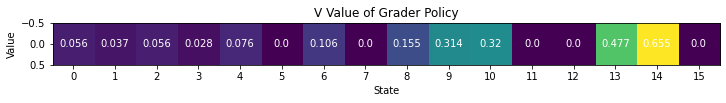

In [137]:
def plot_grader_v_value():
    grader_policy = np.zeros(shape=(num_states, num_actions))
    grader_policy[ 0:12, 1] = 1.
    grader_policy[12:16, 2] = 1.
    grader_v_value = policy_evaluation_v(grader_policy, transition_fn, reward_fn)

    fig, ax = plt.subplots()
    im = ax.imshow(grader_v_value.reshape((1, num_states)), cmap="viridis")

    ax.set_xticks(np.arange(num_states))

    for s in range(num_states):
        text = ax.text(s, 0, round(grader_v_value[s],3), ha="center", va="center", color="w", fontsize=10)

    ax.set_title('V Value of Grader Policy')
    fig.set_size_inches(10., 10.)
    fig.tight_layout()
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.show()

plot_grader_v_value()

# Problem 1.3

Next, we will write a program to compute the q value of a policy.

In [138]:
def policy_evaluation_q(policy, transition_fn, reward_fn, gamma=0.99, theta=1e-6):
    """Implements the policy evaluation algorithm to compute Q values.

    Args:
        policy: A numpy ndarray of shape (num_states, num_actions) denoting
            the probability of selecting an action (a) in a given state (s).
        transition_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the transition probabilities, T(s, a, s')
        reward_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the reward of R(s, a, s').
        gamma: Discount factor.
        theta: Threshold for terminating policy evaluation.

    Returns:
        q_value: A numpy ndarray of shape (num_states, num_actions) denoting the value
            of state (s) for the given policy.
    """
    # Ensure input dimensions are consistent.
    num_states, num_actions, _ = transition_fn.shape
    assert_equal(num_states, transition_fn.shape[2])
    assert_equal(reward_fn.shape, transition_fn.shape)
    assert_equal(policy.shape, (num_states, num_actions))

    # Initialize value
    q_value = np.zeros(shape=(num_states, num_actions))

    # First, we compute V value
    v_value = policy_evaluation_v(policy,
                                  transition_fn,
                                  reward_fn,
                                  gamma,
                                  theta)

    # Then, we use the relation between V and Q to obtain Q value.
    ######## PUT YOUR CODE HERE ########

    # Loop through each state and action
    for s in range(num_states):
        for a in range(num_actions):

            # Initialize sum
            sum3 = 0

            # Loop through each next possible state
            for s_prime, prob in enumerate(transition_fn[s, a, :]):

                # Calculate sum
                sum3 += prob * v_value[s_prime]

            # Update q_value
            q_value[s, a] = sum(np.multiply(reward_fn[s, a, :], transition_fn[s, a, :])) + (gamma * sum3)


    ######## PUT YOUR CODE HERE ########

    return q_value

#### Test Code
You can use the test code to check and develop your solution.

In [139]:
def test_policy_evaluation_q(test_policy, test_q_value, transition_fn, reward_fn, test_policy_name):
    """Test code for policy evaluation of Q values."""
    q_value = policy_evaluation_q(test_policy, transition_fn, reward_fn)
    try:
        assert_almost_equal(q_value, test_q_value, decimal=2)
    except AssertionError:
        print("The Q value of " + test_policy_name + " is incorrect.")
    else:
        print("The Q value of " + test_policy_name + " is correct to at least 2 decimal values.")

In [140]:
a_test_policy = np.full(fill_value=1. / num_actions, shape=(num_states, num_actions))
a_test_q_value = np.array(
      [[0.01303267, 0.01239558, 0.01239558, 0.01159293],
       [0.00751626, 0.010458  , 0.00982091, 0.01389758],
       [0.02265597, 0.01940204, 0.02234378, 0.01294831],
       [0.00950873, 0.00950873, 0.0062548 , 0.01263612],
       [0.01971462, 0.01563795, 0.0148353 , 0.00895599],
       [0.        , 0.        , 0.        , 0.        ],
       [0.05185885, 0.04547752, 0.05185885, 0.00638133],
       [0.        , 0.        , 0.        , 0.        ],
       [0.01563795, 0.03858996, 0.03271066, 0.04346928],
       [0.06697237, 0.11244989, 0.10169126, 0.05623615],
       [0.18374757, 0.17091251, 0.15591623, 0.0406664 ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.08404508, 0.19929491, 0.22712625, 0.17091251],
       [0.24477244, 0.53262825, 0.52189203, 0.43502459],
       [0.        , 0.        , 0.        , 0.        ]])
test_policy_evaluation_q(a_test_policy, a_test_q_value, transition_fn, reward_fn, "policy A")

The Q value of policy A is correct to at least 2 decimal values.


In [141]:
b_test_policy  = np.zeros(shape=(num_states, num_actions))
b_test_policy[:,2] = 1.
b_test_q_value = np.array(
       [[0.03103443, 0.02883884, 0.02883884, 0.02635436],
        [0.01683771, 0.02438069, 0.02218509, 0.03170175],
        [0.05236364, 0.03749961, 0.04504259, 0.02218509],
        [0.01486404, 0.01486404, 0.        , 0.01486404],
        [0.04836826, 0.03885161, 0.03636713, 0.02151778],
        [0.        , 0.        , 0.        , 0.        ],
        [0.09145016, 0.07658612, 0.09145016, 0.01486404],
        [0.        , 0.        , 0.        , 0.        ],
        [0.03885161, 0.09621449, 0.08136514, 0.10821562],
        [0.1604584 , 0.23704453, 0.21019404, 0.1034366 ],
        [0.30144318, 0.27126463, 0.23207917, 0.09954256],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.20297193, 0.33550854, 0.40487255, 0.27126463],
        [0.41209467, 0.66884188, 0.61182008, 0.54352738],
        [0.        , 0.        , 0.        , 0.        ]])
test_policy_evaluation_q(b_test_policy, b_test_q_value, transition_fn, reward_fn, "policy B")

The Q value of policy B is correct to at least 2 decimal values.


In [142]:
c_test_policy  = np.zeros(shape=(num_states, num_actions))
c_test_policy[:,1] = 0.
c_test_q_value = np.zeros(shape=(num_states, num_actions))
c_test_q_value[14,1:4] = 1./3.
test_policy_evaluation_q(c_test_policy, c_test_q_value, transition_fn, reward_fn, "policy C")

The Q value of policy C is correct to at least 2 decimal values.


#### Grader Code
Report the output of the grader code in your pdf submission.

In [143]:
test_policy_evaluation_q(a_test_policy, a_test_q_value, transition_fn, reward_fn, "policy A")
test_policy_evaluation_q(b_test_policy, b_test_q_value, transition_fn, reward_fn, "policy B")
test_policy_evaluation_q(c_test_policy, c_test_q_value, transition_fn, reward_fn, "policy C")

The Q value of policy A is correct to at least 2 decimal values.
The Q value of policy B is correct to at least 2 decimal values.
The Q value of policy C is correct to at least 2 decimal values.


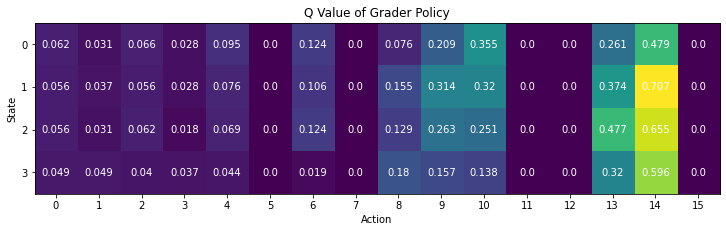

In [144]:
def plot_grader_q_value():
    grader_policy = np.zeros(shape=(num_states, num_actions))
    grader_policy[ 0:12, 1] = 1.
    grader_policy[12:16, 2] = 1.
    grader_q_value = policy_evaluation_q(grader_policy, transition_fn, reward_fn)

    fig, ax = plt.subplots()
    im = ax.imshow(grader_q_value.transpose(), cmap="viridis")

    ax.set_yticks(np.arange(num_actions))
    ax.set_xticks(np.arange(num_states))

    for s in range(num_states):
        for a in range(num_actions):
            text = ax.text(s, a, round(grader_q_value[s,a],3), ha="center", va="center", color="w", fontsize=10)

    ax.set_title('Q Value of Grader Policy')
    fig.set_size_inches(10., 10.)
    fig.tight_layout()
    plt.xlabel('Action')
    plt.ylabel('State')
    plt.show()

plot_grader_q_value()

# Problem 2.1

In this problem, we will use the value iteration algorithm to compute the optimal policy.

In [145]:
def value_iteration(transition_fn, reward_fn, gamma=0.99, theta=1e-6):
    """Implements the value iteration algorithm.

    Args:
        transition_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the transition probabilities, T(s, a, s')
        reward_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the reward of R(s, a, s').
        gamma: Discount factor.
        theta: Threshold for terminating policy evaluation.

    Returns:
        optimal_policy: A numpy ndarray of shape (num_states, num_actions) denoting
            the probability of selecting an action (a) in a given state (s).
        optimal_v_value: A numpy ndarray of shape (num_states, ) denoting
            the optimal value of each state (s).
    """
    # Ensure input dimensions are consistent.
    num_states, num_actions, _ = transition_fn.shape
    assert_equal(num_states, transition_fn.shape[2])
    assert_equal(reward_fn.shape, transition_fn.shape)

    # Initialize value
    v_value = np.zeros(shape=(num_states, ))

    delta_list = list()
    delta_list2 = list()

    # Perform value iteration to compute optimal V
    num_iteration = 0
    while True:
        delta = 0
        delta2 = 0 
        ######## PUT YOUR CODE HERE ########

        

        # Loop through each state
        for s in range(num_states):
            # Save current value for state
            current_v = v_value[s]
            # Initialize outer sum
            list1 = list()
            # Loop through actions
            for a in range(num_actions):

                sum4 = sum(np.multiply(transition_fn[s, a, :], (reward_fn[s, a, :] + gamma*v_value[:])))

                
                list1.append(sum4)

            # Set new value for state    
            v_value[s] = max(list1)
            # Calculate delta
            delta = max(delta, np.abs(current_v - v_value[s]))
            delta2 = max(delta2, np.abs(current_v - final_v_value[s]))

        delta_list.append(delta)
        delta_list2.append(delta2)
        ######## PUT YOUR CODE HERE ########
        num_iteration += 1
        if delta < theta:
            break
    optimal_v_value = v_value


    # Compute optimal Q from optimal V
    optimal_q_value = np.zeros(shape=(num_states, num_actions))
    ######## PUT YOUR CODE HERE ########

        # Loop through each state and action
    for s in range(num_states):
        for a in range(num_actions):

            # Initialize sum
            sum3 = 0

            # Loop through each next possible state
            for s_prime, prob in enumerate(transition_fn[s, a, :]):

                # Calculate sum
                sum3 += prob * optimal_v_value[s_prime]

            # Update q_value
            optimal_q_value[s, a] = sum(np.multiply(reward_fn[s, a, :], transition_fn[s, a, :])) + (gamma * sum3)


    ######## PUT YOUR CODE HERE ########

    # Compute optimal policy from optimal Q
    optimal_policy = np.zeros(shape=(num_states, num_actions))
    for s in range(num_states):
        optimal_action_in_s = optimal_q_value[s].argmax()
        optimal_policy[s, optimal_action_in_s] = 1.

    return (optimal_policy, optimal_v_value, delta_list, delta_list2, num_iteration)

#### Test Code
You can use the test code to check and develop your solution.

In [146]:
def test_value_iteration(test_v_value, transition_fn, reward_fn, gamma):
    """Test code for value iteration."""
    _, optimal_v_value, _, _ = value_iteration(transition_fn, reward_fn, gamma)
    try:
        assert_almost_equal(test_v_value, optimal_v_value, decimal=2)
    except AssertionError:
        print("The optimal V value for gamma = " + str(gamma) + " is incorrect.")
    else:
        print("The optimal V value for gamma = " + str(gamma) + " is correct.")

In [147]:
test_v_value_for_gamma_000 = np.array(
     [0.       ,0.       ,0.       ,0.      ,
      0.       ,0.       ,0.       ,0.      ,
      0.       ,0.       ,0.       ,0.      ,
      0.       ,0.       ,0.333333 ,0.      ])
test_value_iteration(test_v_value_for_gamma_000, transition_fn, reward_fn, gamma=0.0)

ValueError: too many values to unpack (expected 4)

In [ ]:
test_v_value_for_gamma_090 = np.array(
    [0.068886 ,0.061411 ,0.074408 ,0.055805,
     0.091851 ,0.       ,0.112207 ,0.      ,
     0.145434 ,0.247496 ,0.299617 ,0.      ,
     0.       ,0.379935 ,0.63902  ,0.      ])
test_value_iteration(test_v_value_for_gamma_090, transition_fn, reward_fn, gamma=0.9)

The optimal V value for gamma = 0.9 is correct.


A helper function to run and render a policy.
Note: The rendering will not work on Google Colab.

In [148]:
def render_policy(policy):
    """Renders a policy for the Frozen Lake environment.

    Args:
        policy: A numpy ndarray of shape (num_states, num_actions) denoting
            the probability of selecting an action (a) in a given state (s).

    Returns:
        None
    """
    env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="human")
    assert_equal(policy.shape, (env.observation_space.n, env.action_space.n))
    state, _ = env.reset()
    while True:
        action = policy[state].argmax()
        next_state, _, is_terminal, _, _ = env.step(action)
        if is_terminal:
            env.close()
            break
        state = next_state

In [149]:
optimal_policy, _ = value_iteration(transition_fn, reward_fn, gamma=0.99)
try:
    render_policy(optimal_policy)
except Exception as e:
    print(e)
    print("Either your python runtime does not support rendering...")
    print("or your pygame installation is incorrect.")

ValueError: too many values to unpack (expected 2)

#### Grader Code
Report the output of the grader code in your pdf submission.

In [ ]:
test_value_iteration(test_v_value_for_gamma_000, transition_fn, reward_fn, gamma=0.0)
test_value_iteration(test_v_value_for_gamma_090, transition_fn, reward_fn, gamma=0.9)

The optimal V value for gamma = 0.0 is correct.
The optimal V value for gamma = 0.9 is correct.


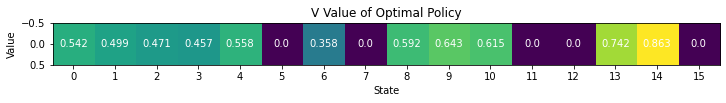

In [ ]:
def plot_grader_value_iteration():
    grader_optimal_policy, grader_optimal_v_value, _, _ = value_iteration(transition_fn, reward_fn, gamma=0.99)

    fig, ax = plt.subplots()
    im = ax.imshow(grader_optimal_v_value.reshape((1, num_states)), cmap="viridis")

    ax.set_xticks(np.arange(num_states))

    for s in range(num_states):
        text = ax.text(s, 0, round(grader_optimal_v_value[s],3), ha="center", va="center", color="w", fontsize=10)

    ax.set_title('V Value of Optimal Policy')
    fig.set_size_inches(10., 10.)
    fig.tight_layout()
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.show()

plot_grader_value_iteration()

# Problem 2.2

Insert your code to generate the plots here.

ValueError: x and y must have same first dimension, but have shapes (60,) and (611,)

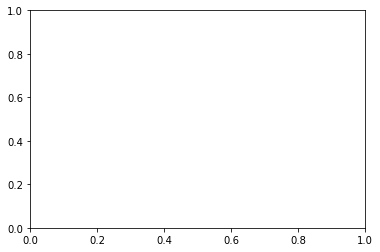

In [150]:
######## PUT YOUR CODE HERE ########

x = range(60)

# _, final_v_value, delta_list, delta_list2, num_iterations = value_iteration(transition_fn, reward_fn, 0.90)

plt.plot(x, delta_list, delta_list2)
plt.xlabel('Iteration')
plt.ylabel('max Delta')
plt.title('Learning History')
plt.legend(['Minus Last Iteration', 'Minus Final Iteration'])

plt.savefig('2-2.pdf', dpi=300)

######## PUT YOUR CODE HERE ########

# Problem 2.4

Insert your code to generate the plots here.

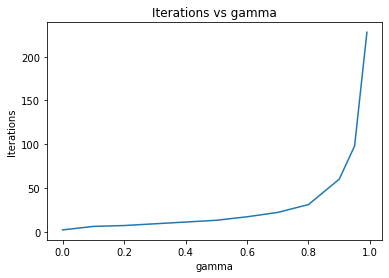

In [151]:
######## PUT YOUR CODE HERE ########

gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

g_list = list()

for g in gamma:
    _, final_v_value, delta_list, delta_list2, num_iterations = value_iteration(transition_fn, reward_fn, g)
    g_list.append(num_iterations)

plt.plot(gamma, g_list)
plt.xlabel('gamma')
plt.ylabel('Iterations')
plt.title('Iterations vs gamma')

plt.savefig('2-4.pdf', dpi=300)


######## PUT YOUR CODE HERE ########

# Problem 2.5

In [152]:
guess_policy = np.array(
       [[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]])

In [153]:
def value_iteration_with_guess_policy(transition_fn, reward_fn, gamma=0.99, theta=1e-6, guess_policy=None):
    """Implements the value iteration algorithm.

    Args:
        transition_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the transition probabilities, T(s, a, s')
        reward_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the reward of R(s, a, s').
        gamma: Discount factor.
        theta: Threshold for terminating policy evaluation.
        guess_policy: A numpy ndarray of shape (num_states, num_actions) denoting
            the probability of selecting an action (a) in a given state (s).

    Returns:
        optimal_policy: A numpy ndarray of shape (num_states, num_actions) denoting
            the probability of selecting an action (a) in a given state (s).
        optimal_v_value: A numpy ndarray of shape (num_states, ) denoting
            the optimal value of each state (s).
    """
    # Ensure input dimensions are consistent.
    num_states, num_actions, _ = transition_fn.shape
    assert_equal(num_states, transition_fn.shape[2])
    assert_equal(reward_fn.shape, transition_fn.shape)

    # Initialize value using guess policy
    if guess_policy is None:
        v_value = np.zeros(shape=(num_states, ))
    else:
        ######## PUT YOUR CODE HERE ########

        v_value = policy_evaluation_v(guess_policy, transition_fn, reward_fn, gamma=0.99, theta=1e-6)

        ######## PUT YOUR CODE HERE ########

    # Perform value iteration to compute optimal V
    num_iteration = 0
    while True:
        delta = 0
        ######## PUT YOUR CODE HERE ########


        # Loop through each state
        for s in range(num_states):
            # Save current value for state
            current_v = v_value[s]
            # Initialize outer sum
            list1 = list()
            # Loop through actions
            for a in range(num_actions):

                sum4 = sum(np.multiply(transition_fn[s, a, :], (reward_fn[s, a, :] + gamma*v_value[:])))

                
                list1.append(sum4)

            # Set new value for state    
            v_value[s] = max(list1)
            # Calculate delta
            delta = max(delta, np.abs(current_v - v_value[s]))


        delta_list.append(delta)

        ######## PUT YOUR CODE HERE ########
        num_iteration += 1
        if delta < theta:
            break
    optimal_v_value = v_value
    print("Number of iterations = " + str(num_iteration))

    # Compute optimal Q from optimal V
    optimal_q_value = np.zeros(shape=(num_states, num_actions))
    ######## PUT YOUR CODE HERE ########
        # Loop through each state and action
    for s in range(num_states):
        for a in range(num_actions):

            # Initialize sum
            sum3 = 0

            # Loop through each next possible state
            for s_prime, prob in enumerate(transition_fn[s, a, :]):

                # Calculate sum
                sum3 += prob * optimal_v_value[s_prime]

            # Update q_value
            optimal_q_value[s, a] = sum(np.multiply(reward_fn[s, a, :], transition_fn[s, a, :])) + (gamma * sum3)


    ######## PUT YOUR CODE HERE ########

    # Compute optimal policy from optimal Q
    optimal_policy = np.zeros(shape=(num_states, num_actions))
    for s in range(num_states):
        optimal_action_in_s = optimal_q_value[s].argmax()
        optimal_policy[s, optimal_action_in_s] = 1.

    return (optimal_policy, optimal_v_value)

#### Grader Code

In [154]:
print("Without guess policy: ")
_ = value_iteration_with_guess_policy(transition_fn, reward_fn, gamma=0.99)

print("With guess policy: ")
_ = value_iteration_with_guess_policy(transition_fn, reward_fn, gamma=0.99, guess_policy=guess_policy)

Without guess policy: 
Number of iterations = 228
With guess policy: 
Number of iterations = 155


# Problem 3.2

In this problem, we will use the policy iteration algorithm to compute the optimal policy.

In [155]:
def policy_iteration(transition_fn, reward_fn, gamma=0.99, theta=1e-6):
    """Implements the policy iteration algorithm.

    Args:
        transition_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the transition probabilities, T(s, a, s')
        reward_fn: A numpy ndarray of shape (num_states, num_actions, num_states)
            denoting the reward of R(s, a, s').
        gamma: Discount factor.

    Returns:
        optimal_policy: A numpy ndarray of shape (num_states, num_actions) denoting
            the probability of selecting an action (a) in a given state (s).
    """
    # Ensure input dimensions are consistent.
    num_states, num_actions, _ = transition_fn.shape
    assert_equal(num_states, transition_fn.shape[2])
    assert_equal(reward_fn.shape, transition_fn.shape)

    # Initialize policy
    policy = np.zeros(shape=(num_states, num_actions))

    # Perform policy iteration to compute optimal V
    num_iteration = 0
    while True:
        delta = 0

        # Policy Evaluation
        ######## PUT YOUR CODE HERE ########

        v_value = policy_evaluation_v(policy, transition_fn, reward_fn, gamma=gamma, theta=1e-6)

        ######## PUT YOUR CODE HERE ########

        # Policy Improvement
        ######## PUT YOUR CODE HERE ########
        policy_stable = True
        for s in range(num_states):
            old_action = np.argmax(policy[s])

            sum_list = list()
            for a in range(num_actions):    

                sum5 = 0
                for s_prime, prob in enumerate(transition_fn[s, a, :]):

                # Calculate sum
                    sum5 += prob * (reward_fn[s, a, s_prime] + gamma*v_value[s_prime])

                sum_list.append(sum5)

            policy[s] = [0, 0, 0, 0]
            
            policy[s][np.argmax(sum_list)] = 1

            if old_action != np.argmax(policy[s]):
                policy_stable = False

        ######## PUT YOUR CODE HERE ########

        num_iteration += 1

        
        # Termination Condition
        ######## PUT YOUR CODE HERE ########
        if policy_stable:
            break
        ######## PUT YOUR CODE HERE ########

    optimal_policy = policy.copy()
    optimal_v_value = policy_evaluation_v(policy, transition_fn, reward_fn, gamma)

    return (optimal_policy, optimal_v_value, num_iteration)

In [156]:
policy = np.zeros(shape=(num_states, num_actions))
np.argmax(guess_policy[2, :])

0

#### Test Code

In [160]:
def test_policy_iteration(test_v_value, transition_fn, reward_fn, gamma):
    """Test code for policy iteration."""
    _, optimal_v_value, num_iters = policy_iteration(transition_fn, reward_fn, gamma)
    try:
        assert_almost_equal(test_v_value, optimal_v_value, decimal=2)
    except AssertionError:
        print("The optimal V value for gamma = " + str(gamma) + " is incorrect.")
    else:
        print("The optimal V value for gamma = " + str(gamma) + " is correct.")

In [161]:
test_v_value_for_gamma_000 = np.array(
     [0.       ,0.       ,0.       ,0.      ,
      0.       ,0.       ,0.       ,0.      ,
      0.       ,0.       ,0.       ,0.      ,
      0.       ,0.       ,0.333333 ,0.      ])
test_policy_iteration(test_v_value_for_gamma_000, transition_fn, reward_fn, gamma=0.0)

The optimal V value for gamma = 0.0 is correct.


In [162]:
test_v_value_for_gamma_090 = np.array(
    [0.068886 ,0.061411 ,0.074408 ,0.055805,
     0.091851 ,0.       ,0.112207 ,0.      ,
     0.145434 ,0.247496 ,0.299617 ,0.      ,
     0.       ,0.379935 ,0.63902  ,0.      ])
test_policy_iteration(test_v_value_for_gamma_090, transition_fn, reward_fn, gamma=0.9)

The optimal V value for gamma = 0.9 is correct.


#### Grader Code

In [163]:
test_policy_iteration(test_v_value_for_gamma_000, transition_fn, reward_fn, gamma=0.0)
test_policy_iteration(test_v_value_for_gamma_090, transition_fn, reward_fn, gamma=0.9)

The optimal V value for gamma = 0.0 is correct.
The optimal V value for gamma = 0.9 is correct.


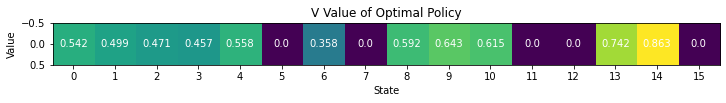

7


In [167]:
def plot_grader_policy_iteration():
    grader_optimal_policy, grader_optimal_v_value, num_iters = policy_iteration(transition_fn, reward_fn, gamma=0.99)

    fig, ax = plt.subplots()
    im = ax.imshow(grader_optimal_v_value.reshape((1, num_states)), cmap="viridis")

    ax.set_xticks(np.arange(num_states))

    for s in range(num_states):
        text = ax.text(s, 0, round(grader_optimal_v_value[s],3), ha="center", va="center", color="w", fontsize=10)

    ax.set_title('V Value of Optimal Policy')
    fig.set_size_inches(10., 10.)
    fig.tight_layout()
    plt.xlabel('State')
    plt.ylabel('Value')
    plt.show()
    print(num_iters)

plot_grader_policy_iteration()

## Halfway There!
Great! You have now completed the programming component of Problems 1-3.